In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import sklearn
sklearn.set_config(transform_output="pandas")

In [2]:
import ctgan

In [3]:
ks = pd.read_csv('ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

In [4]:
ks = ks[['category', 'main_category', 'currency','pledged', 'goal', 'country', 'outcome']]

In [5]:
ks_small = ks.sample(n=10000, random_state=42 )  # Select 10000 random rows from the dataframe

In [6]:
ks_small.head()

,category,main_category,currency,pledged,goal,country,outcome
356490,Shorts,Film & Video,USD,3735.0,3500.0,US,1
211122,Photography,Photography,USD,10.0,5000.0,US,0
302711,Children's Books,Publishing,USD,50.0,5000.0,US,0
62454,Theater,Theater,USD,1770.0,1500.0,US,1
273723,Shorts,Film & Video,USD,0.0,500.0,US,0


In [7]:
ks_small_enc = pd.get_dummies(ks_small, columns = ['category', 'main_category', 'currency', 'country'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ks_small_enc.drop('outcome', axis=1), ks_small_enc['outcome'], test_size=0.2, random_state=42)

# Identify the float columns
float_columns = X_train.select_dtypes(include=np.float64).columns

# Scale only the float columns using StandardScaler
scaler = StandardScaler()
X_train_float = scaler.fit_transform(X_train[float_columns])
X_test_float = scaler.transform(X_test[float_columns])

# Merge the scaled float columns with the remaining columns
X_train_scaled = pd.DataFrame(X_train, columns=X_train.columns)
X_train_scaled[float_columns] = X_train_float

X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns)
X_test_scaled[float_columns] = X_test_float

clf_1 = LogisticRegression(max_iter=10000)
clf_1.fit(X_train_scaled, y_train)
accuracy = clf_1.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.781


In [9]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
y_pred = clf_1.predict(X_test_scaled)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.7228651263042165


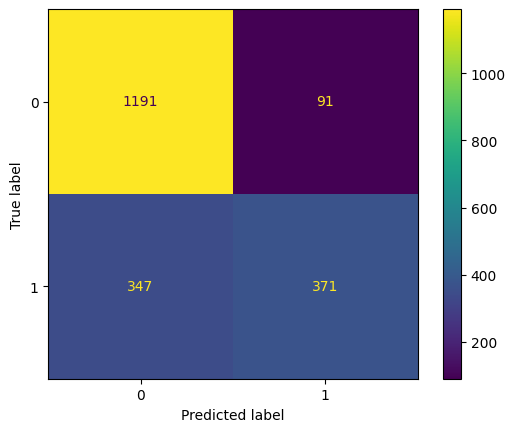

In [10]:
import matplotlib.pyplot as plt
# Compute confusion matrix
cm = confusion_matrix(y_test.values, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_1.classes_)
disp.plot()
plt.show()

# Generate synthetic data

Generate synthetic data with one hot encoding

In [11]:
# Names of the columns that are discrete
discrete_columns = [
    'category',
    'main_category',
    'currency',
    'country'
]

ctgan = ctgan.CTGAN(epochs=100, verbose=True, batch_size=60, discriminator_steps=5)
ctgan.fit(ks_small, discrete_columns = ['category', 'main_category', 'currency', 'country'],
          discrete_encoding = ['one_hot', 'one_hot', 'one_hot', 'one_hot'], 
          target_name='outcome')

C:\Users\SergiBech\anaconda3\envs\ctgan\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\ctgan\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\ctgan\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(

KeyboardInterrupt



In [224]:
#ctgan.save('ctgan_one_hot_2.pkl')
ctgan_one = ctgan.load('ctgan_one_hot_2.pkl')

In [225]:
# Create synthetic data
synthetic_data = ctgan_one.sample(10000)

In [226]:
synthetic_data.head()

,category,main_category,currency,pledged,goal,country,outcome
0,Publishing,Photography,EUR,1148.730145,4958.354007,IT,0
1,Video Games,Publishing,AUD,1624.270816,7782.869574,AU,0
2,Documentary,Film & Video,CAD,154.829172,-6536.314792,SE,0
3,Tabletop Games,Publishing,EUR,682.806969,-583.563829,IE,1
4,Technology,Technology,AUD,-294.374051,230873.628966,AU,0


### Evaluation

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

synthetic_data_enc = pd.get_dummies(synthetic_data, columns = ['category', 'main_category', 'currency', 'country'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synthetic_data_enc.drop('outcome', axis=1), synthetic_data_enc['outcome'], test_size=0.2, random_state=42)

# Identify the float columns
float_columns = X_train.select_dtypes(include=np.float64).columns

# Scale only the float columns using StandardScaler
scaler = StandardScaler()
X_train_float = scaler.fit_transform(X_train[float_columns])
X_test_float = scaler.transform(X_test[float_columns])

# Merge the scaled float columns with the remaining columns
X_train_scaled = pd.DataFrame(X_train, columns=X_train.columns)
X_train_scaled[float_columns] = X_train_float

X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns)
X_test_scaled[float_columns] = X_test_float

clf_2 = LogisticRegression(max_iter=10000)
clf_2.fit(X_train_scaled, y_train)
accuracy = clf_2.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.756


In [228]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
y_pred = clf_2.predict(X_test_scaled)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.5812637543350363


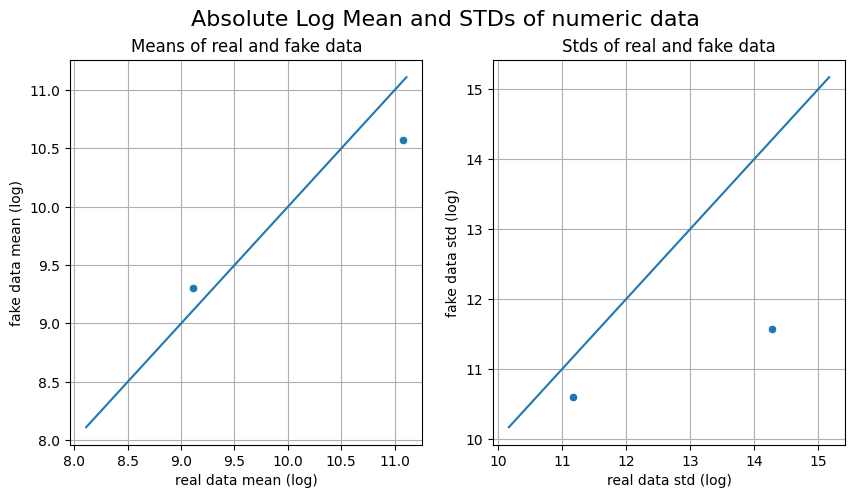

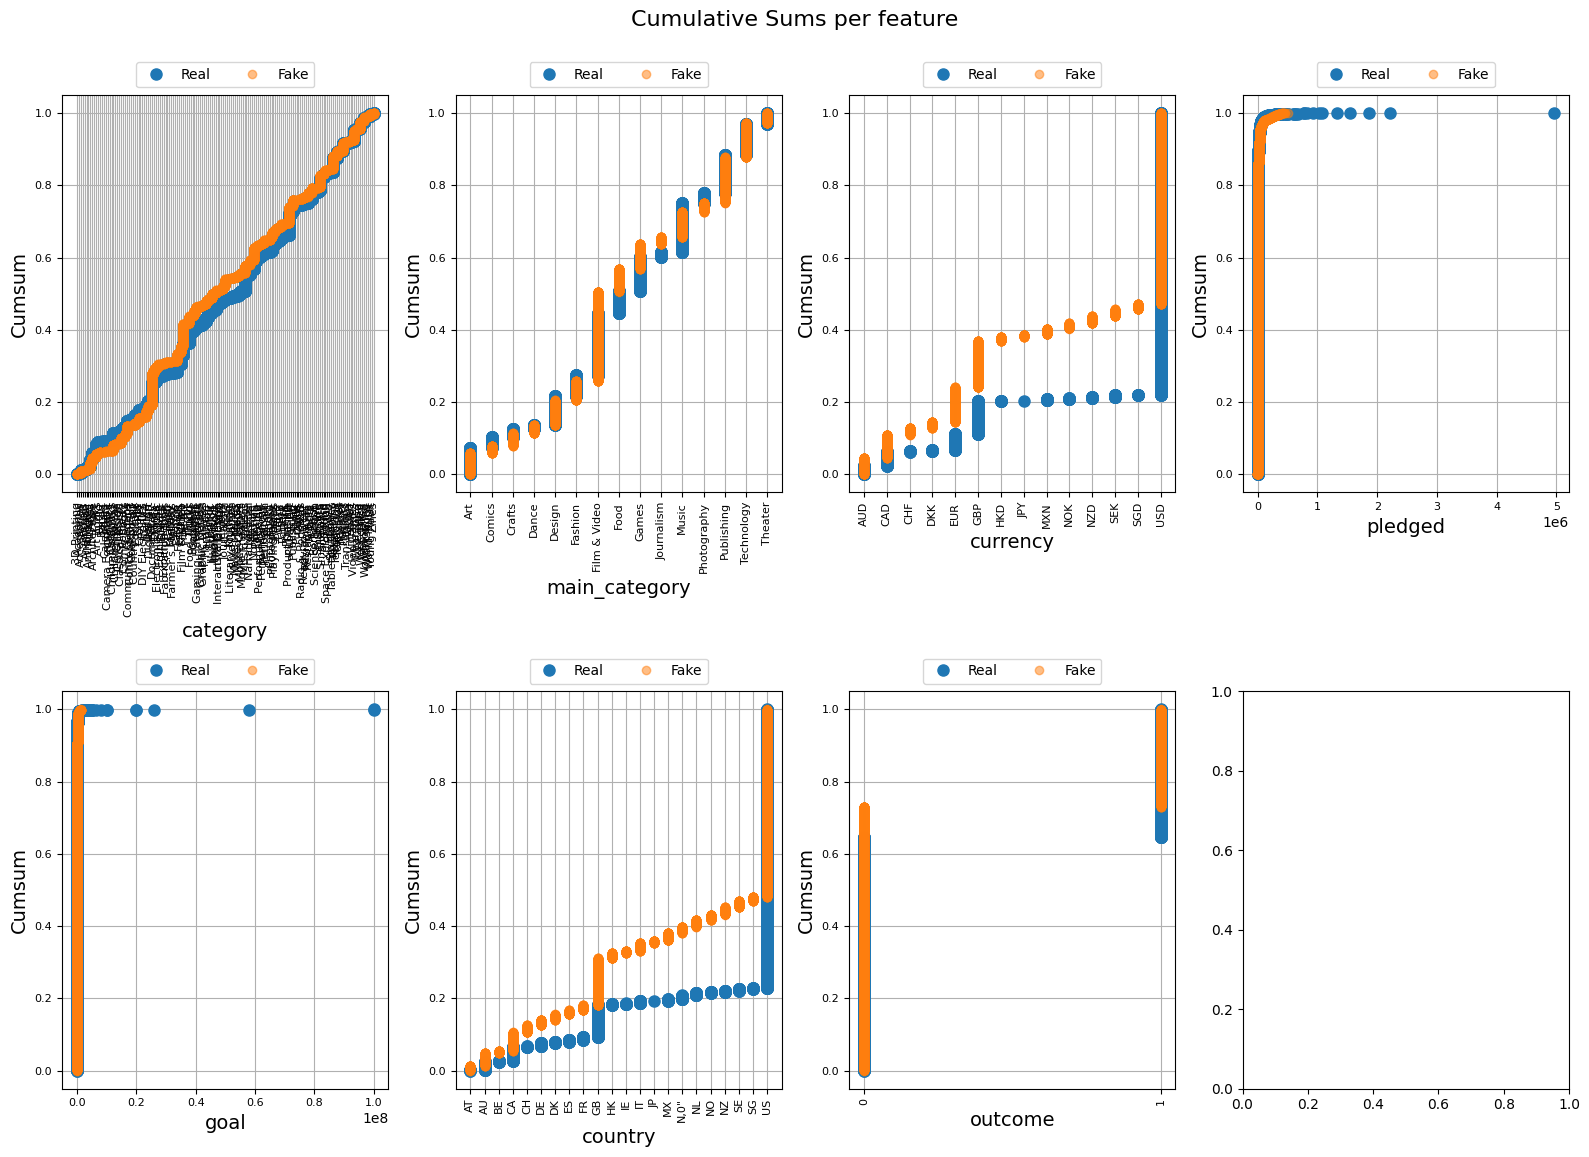

AttributeError: 'Series' object has no attribute 'append'

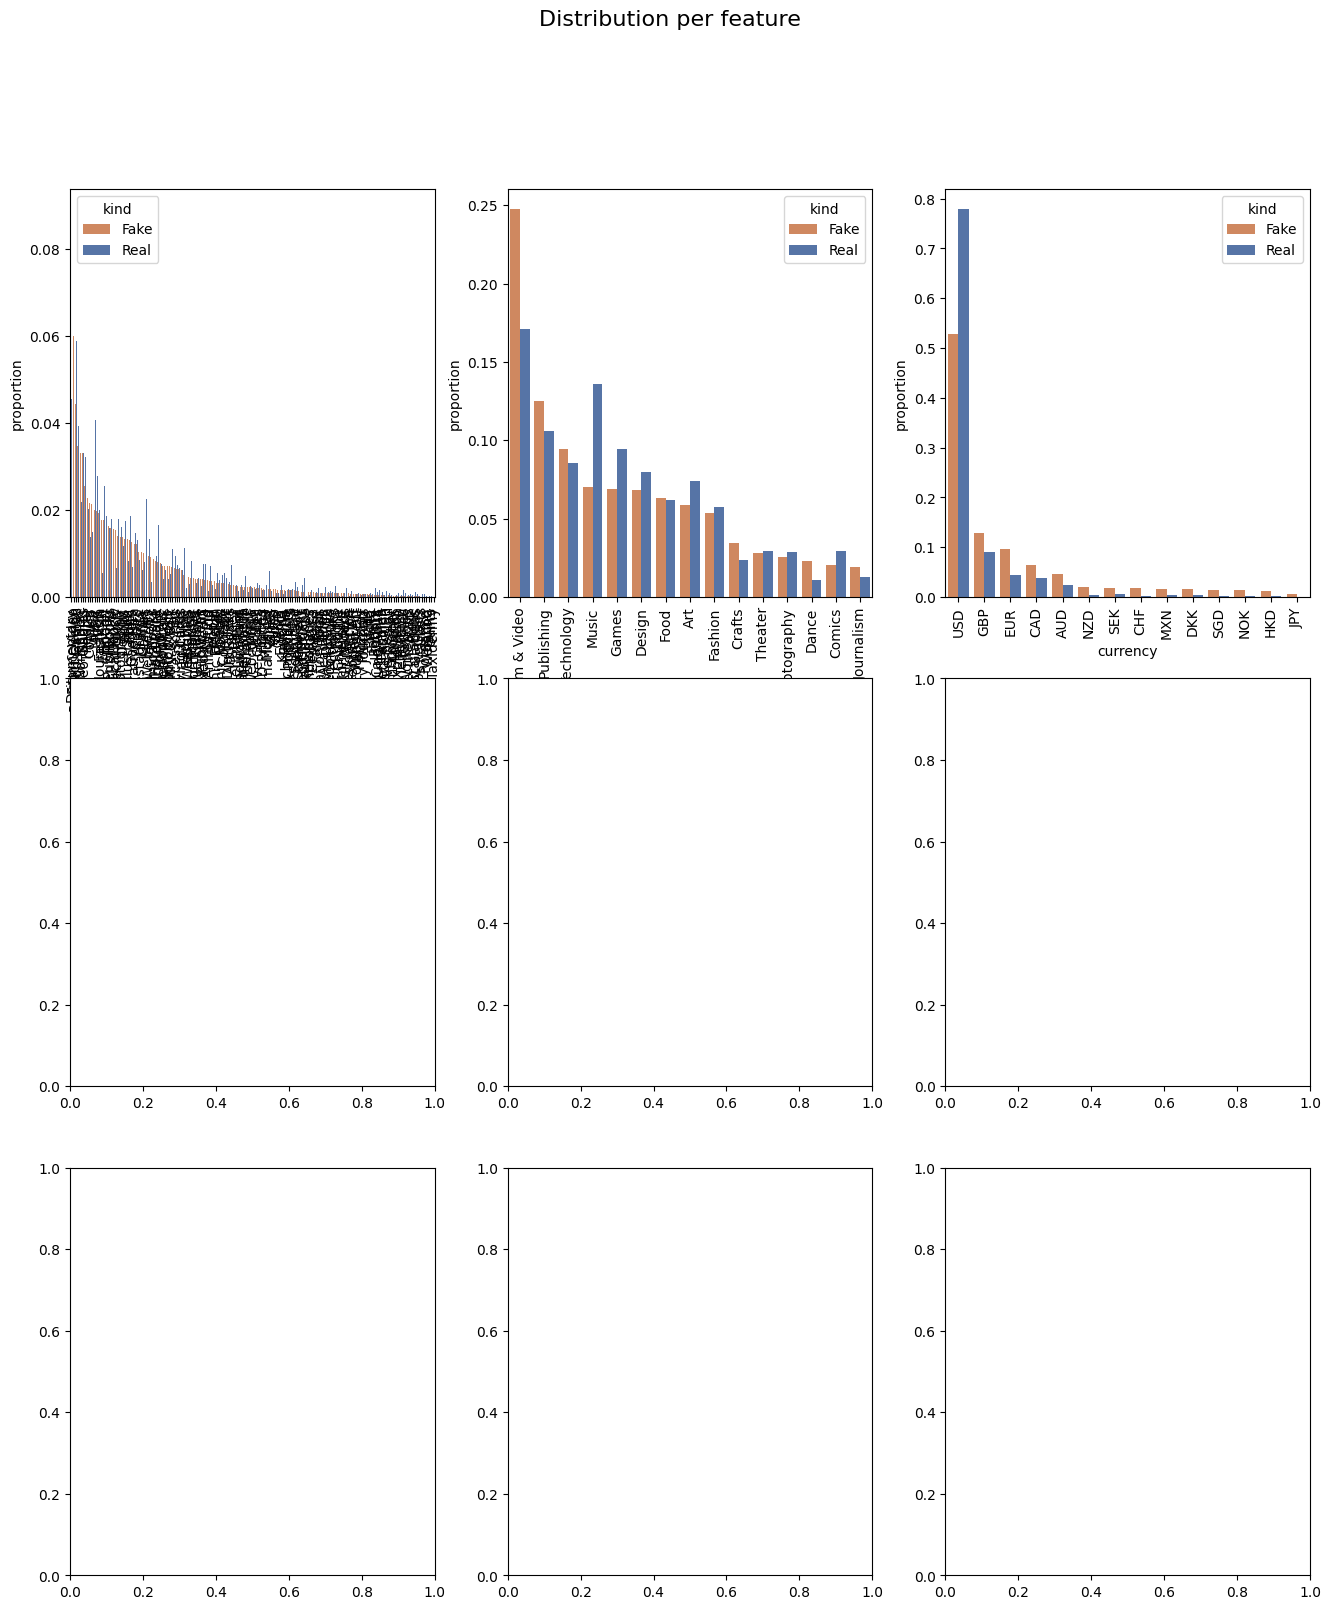

In [229]:
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(ks_small, synthetic_data, cat_cols = ['category',
    'main_category',
    'currency',
    'country', 'outcome'])
table_evaluator.visual_evaluation()

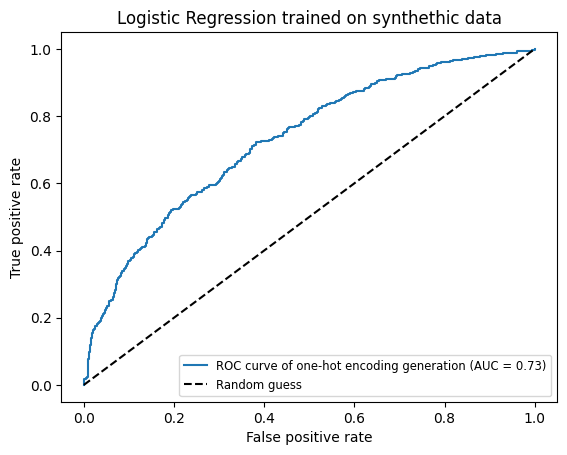

In [230]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr_1, tpr_1, thresholds = roc_curve(y_test,clf_2.predict_proba(X_test_scaled)[:,1])

# Calculate the AUC value
auc_value_1 = auc(fpr_1, tpr_1)

# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr_1, tpr_1, label='ROC curve of one-hot encoding generation (AUC = %0.2f)' % auc_value_1)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression trained on synthethic data')
plt.legend(loc='lower right', fontsize='small')
# Save figure with higher DPI
#plt.savefig('ROC_curve.png', dpi=300)
plt.show()

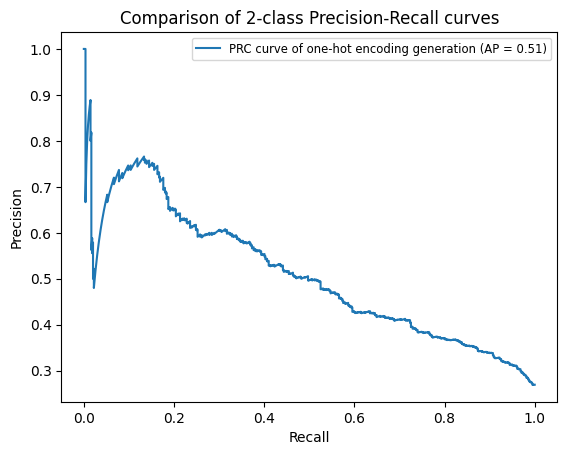

In [231]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision_2, recall_2, threshold_2 = precision_recall_curve(y_test, clf_2.predict_proba(X_test_scaled)[:, 1])

# Create a new figure and axis object
fig, ax = plt.subplots()

ap_2 = auc(recall_2, precision_2)

# Plot the test data Precision-Recall curve
ax.plot(recall_2, precision_2, label='PRC curve of one-hot encoding generation (AP = %0.2f)' % ap_2)

# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Comparison of 2-class Precision-Recall curves")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
#plt.savefig('PRC_curve.png', dpi=300)
plt.show()

# Train with target encoding

In [67]:
# Names of the columns that are discrete
discrete_columns = [
    'category',
    'main_category',
    'currency',
    'country'
]

ctgan = ctgan.CTGAN(epochs=100, verbose=True, batch_size=60, discriminator_steps=5)
ctgan.fit(ks_small, discrete_columns = ['category', 'main_category', 'currency', 'country'],
          discrete_encoding = ['target_encoding', 'one_hot', 'one_hot', 'one_hot'], 
          target_name='outcome')

C:\Users\SergiBech\anaconda3\envs\ctgan\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\ctgan\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\ctgan\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(

KeyboardInterrupt



In [232]:
#ctgan.save('ctgan_target_encoding_2.pkl')
ctgan_target = ctgan.load('ctgan_target_encoding_2.pkl')

In [238]:
# Create synthetic data
synthetic_data = ctgan_target.sample(10000)

In [239]:
synthetic_data.head()

,category,main_category,currency,pledged,goal,country,outcome
0,Faith,Music,USD,-338.784979,5540.354538,US,0
1,Conceptual Art,Music,USD,800.094226,-6891.083841,US,0
2,Software,Publishing,USD,-869.977400,17938.144405,US,0
3,Painting,Publishing,GBP,-650.183204,8188.519939,GB,0
4,Print,Art,GBP,958.794969,8267.635876,NZ,0


In [240]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

synthetic_data_enc = pd.get_dummies(synthetic_data, columns = ['category', 'main_category', 'currency', 'country'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synthetic_data_enc.drop('outcome', axis=1), synthetic_data_enc['outcome'], test_size=0.2, random_state=42)

# Identify the float columns
float_columns = X_train.select_dtypes(include=np.float64).columns

# Scale only the float columns using StandardScaler
scaler = StandardScaler()
X_train_float = scaler.fit_transform(X_train[float_columns])
X_test_float = scaler.transform(X_test[float_columns])

# Merge the scaled float columns with the remaining columns
X_train_scaled = pd.DataFrame(X_train, columns=X_train.columns)
X_train_scaled[float_columns] = X_train_float

X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns)
X_test_scaled[float_columns] = X_test_float

clf_3 = LogisticRegression(max_iter=10000)
clf_3.fit(X_train_scaled, y_train)
accuracy = clf_3.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.711


In [241]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
y_pred = clf_3.predict(X_test_scaled)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.6228633045199838


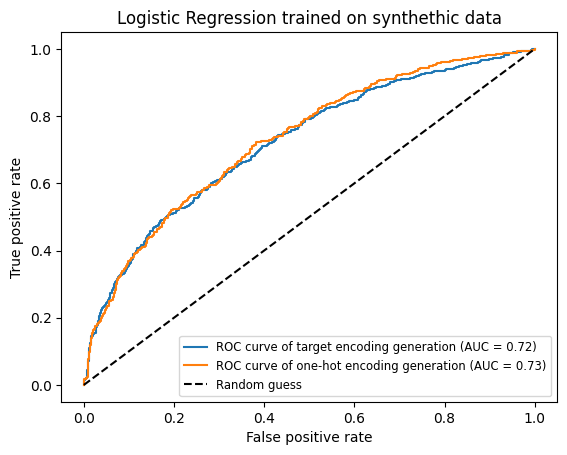

In [244]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,clf_3.predict_proba(X_test_scaled)[:,1])

# Calculate the AUC value
auc_value = auc(fpr, tpr)

# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of target encoding generation (AUC = %0.2f)' % auc_value)
plt.plot(fpr_1, tpr_1, label='ROC curve of one-hot encoding generation (AUC = %0.2f)' % auc_value_1)


plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression trained on synthethic data')
plt.legend(loc='lower right', fontsize='small')
# Save figure with higher DPI
plt.savefig('ROC_gan_encoding.png', dpi=300)
plt.show()

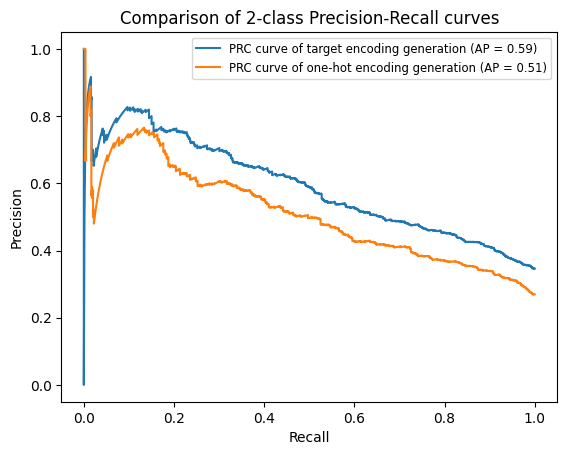

In [245]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision, recall, threshold = precision_recall_curve(y_test, clf_3.predict_proba(X_test_scaled)[:, 1])

# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(recall, precision)

# Plot the test data Precision-Recall curve
ax.plot(recall, precision, label='PRC curve of target encoding generation (AP = %0.2f)' % ap)
ax.plot(recall_2, precision_2, label='PRC curve of one-hot encoding generation (AP = %0.2f)' % ap_2)

# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Comparison of 2-class Precision-Recall curves")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
plt.savefig('PRC_gan_encoding.png', dpi=300)
plt.show()

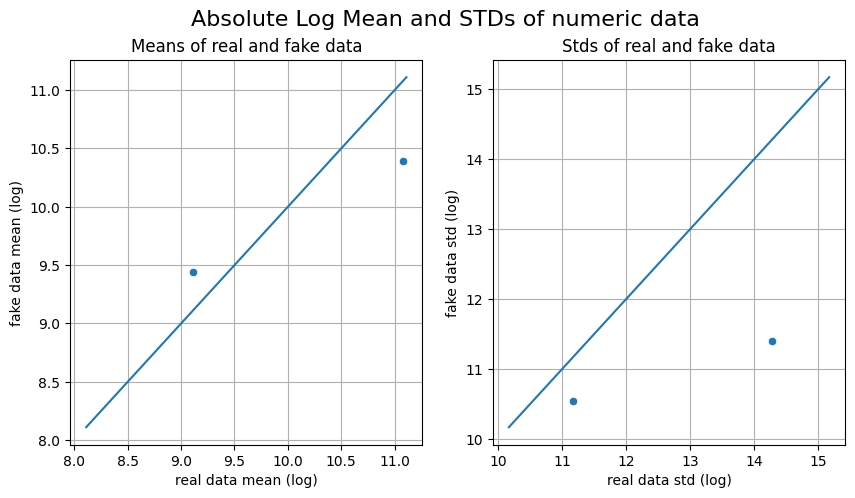

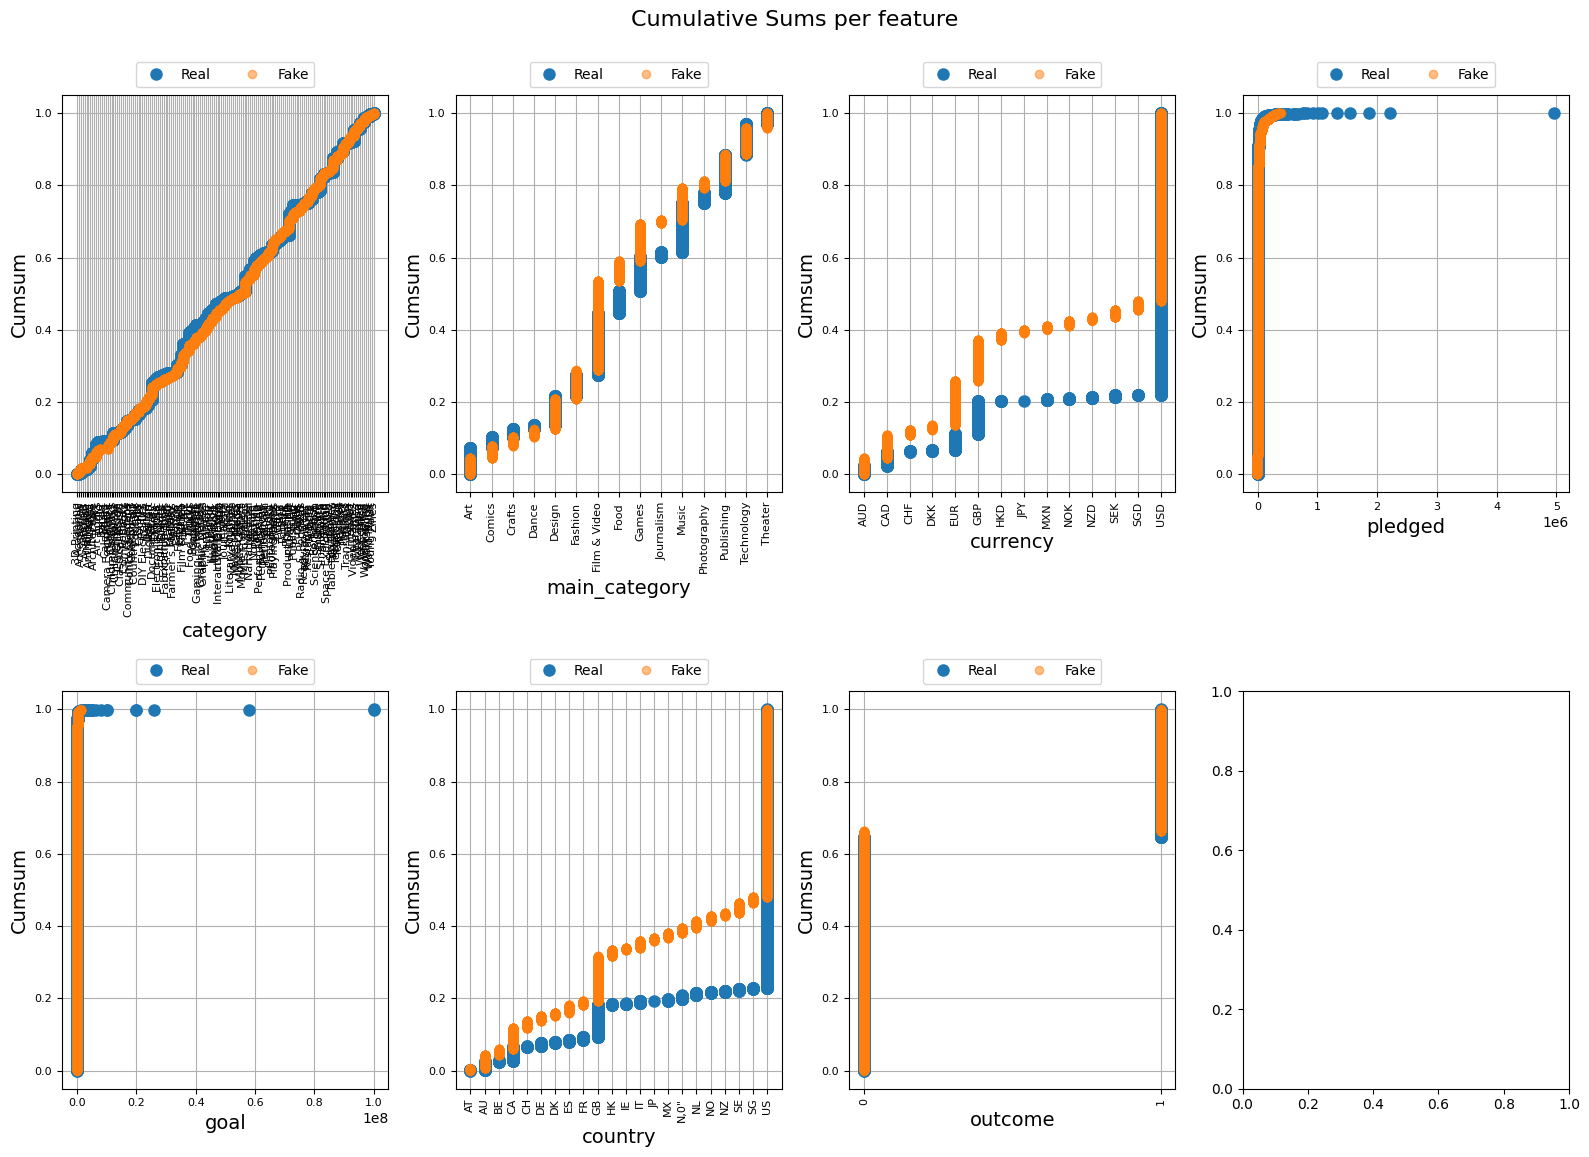

AttributeError: 'Series' object has no attribute 'append'

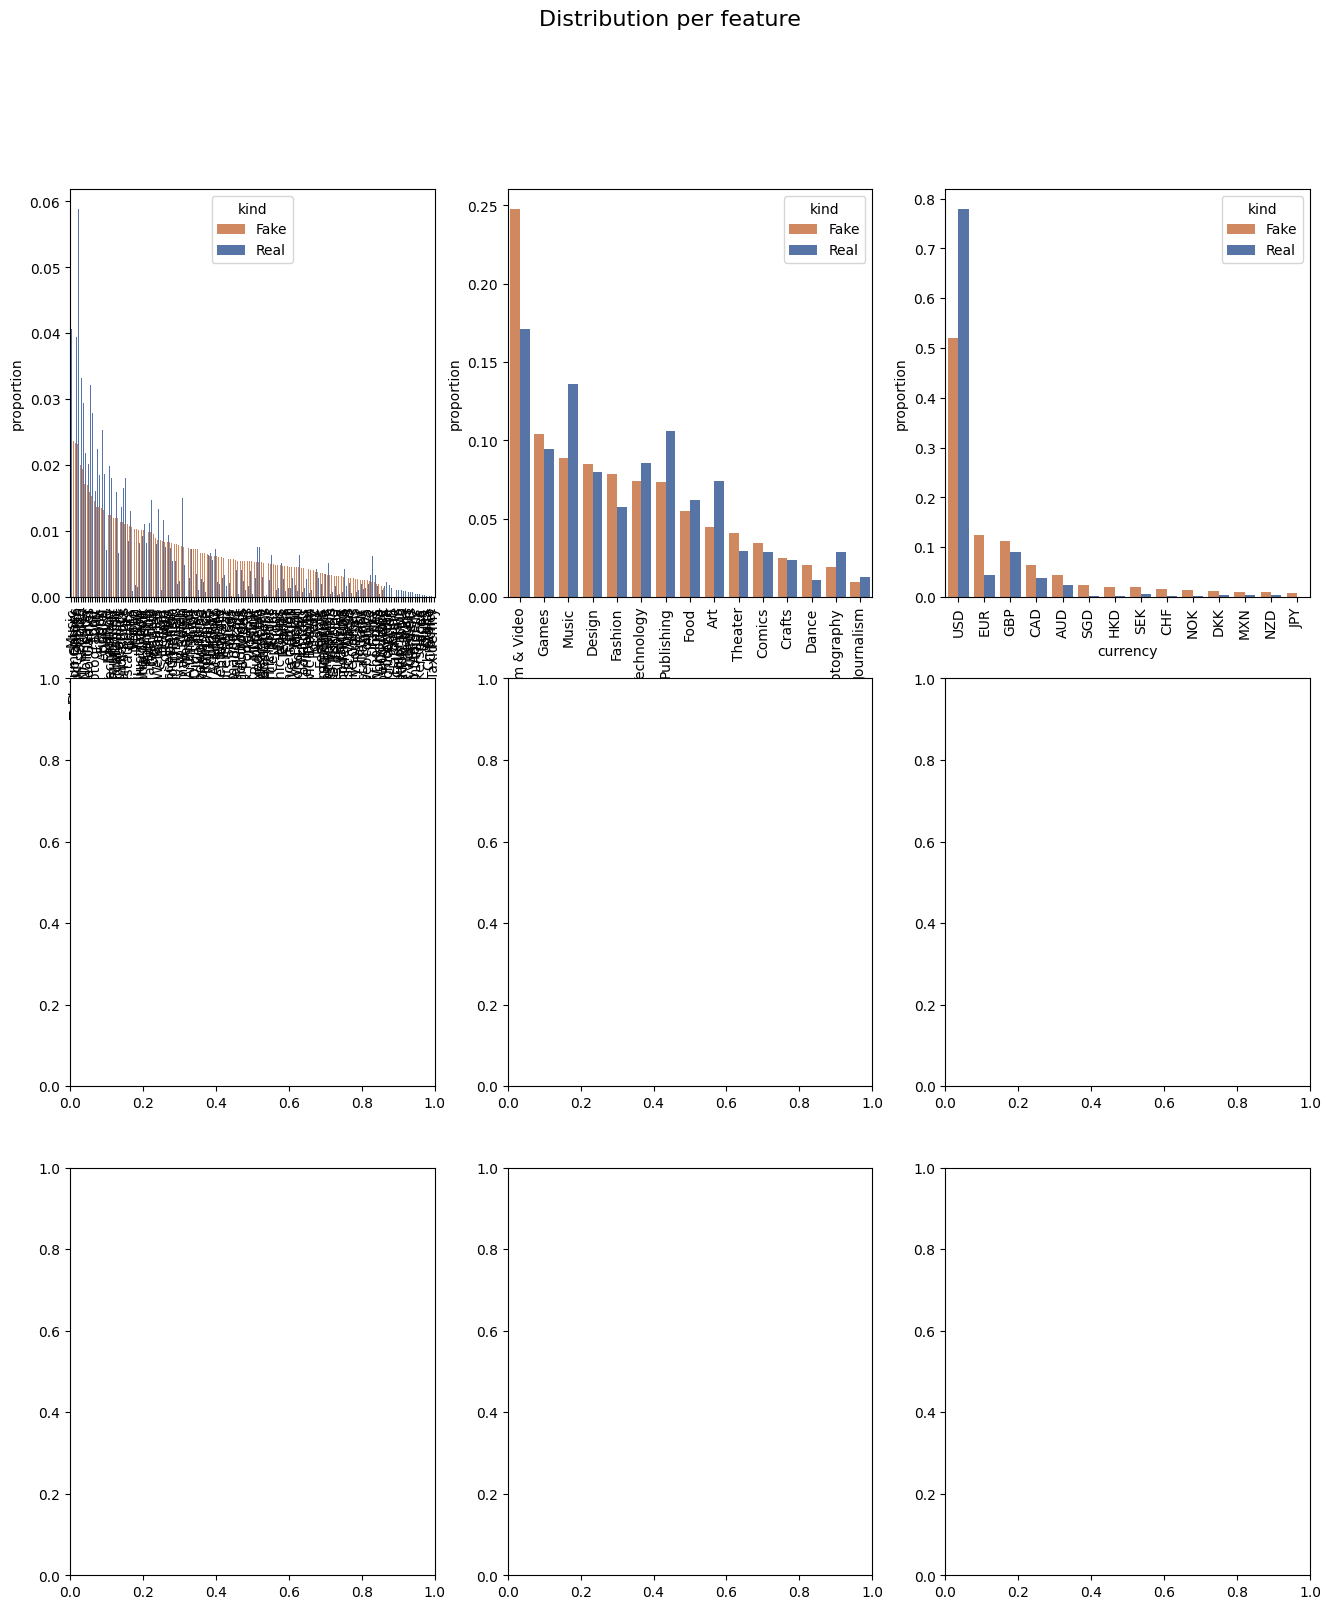

In [246]:
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(ks_small, synthetic_data, cat_cols = ['category',
    'main_category',
    'currency',
    'country', 'outcome'])
table_evaluator.visual_evaluation()